# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Libraries and Define Paths**

In [ ]:
import os, torch, json, shutil, numpy as np, pandas as pd
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

# Define file paths
train_csv_path = "/content/drive/MyDrive/Dataset/train/other/train.csv"
label_map_path = "/content/drive/MyDrive/Dataset/train/other/label_num_to_disease_map.json"
train_images_path = "/content/drive/MyDrive/Dataset/train/train_data"
model_save_path = "/content/drive/MyDrive/Dataset/train/crop_disease_models"

# Create model save directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# **Define CustomDataset Class**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        # Read meta data
        meta_data = pd.read_csv(train_csv_path)
        # Read json file and get class names dictionary
        with open(label_map_path) as json_file:
            data = json.load(json_file)
        self.cls_names = {int(key): value for key, value in data.items()}
        # Get image file names and their corresponding labels
        im_names = list(meta_data["image_id"])
        gt_names = list(meta_data["label"])
        self.meta_data = {}
        self.cls_counts, count, data_count = {}, 0, 0
        for idx, im_path in enumerate(im_names):
            fname = f"{train_images_path}/{im_path}"
            if not os.path.isfile(fname):
                continue
            else:
                class_name = self.cls_names[int(gt_names[idx])]
                if class_name not in self.cls_counts:
                    self.cls_counts[class_name] = 1
                    count += 1
                else:
                    self.cls_counts[class_name] += 1
                self.meta_data[fname] = int(gt_names[idx])

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        im_path = list(self.meta_data.keys())[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.meta_data[im_path]
        if self.transformations is not None:
            im = self.transformations(im)
        return im, gt

# **Define get_dls Function and Load Data**

In [ ]:
def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
    ds = CustomDataset(root=root, transformations=transformations)
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    tr_ds, vl_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, vl_len, ts_len])
    tr_dl, val_dl, ts_dl = (
        DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns),
        DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns),
        DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns),
    )
    return tr_dl, val_dl, ts_dl, ds.cls_names


mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])

tr_dl, val_dl, ts_dl, classes = get_dls(
    root=train_images_path, transformations=tfs, bs=32
)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
for key, value in classes.items():
    print(f"{key}: {value}")


476
27
846
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **Data Visualization Functions**

In [ ]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type="rgb"):
    gray_tfs = T.Compose(
        [
            T.Normalize(mean=[0.0], std=[1 / 0.5]),
            T.Normalize(mean=[-0.5], std=[1]),
        ]
    )
    rgb_tfs = T.Compose(
        [
            T.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
        ]
    )
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs
    return (
        (invTrans(t) * 255)
        .detach()
        .squeeze()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
        if t_type == "gray"
        else (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    )


def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb":
        cmap = "viridis"
    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis("off")
        if cls_names is not None:
            plt.title(f"GT -> {cls_names[int(gt)]}")
        else:
            plt.title(f"GT -> {gt}")


visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.values()))
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.values()))
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.values()))

# **Data Analysis Function**

<ipython-input-6-b5ebb4d7a923>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation=60)


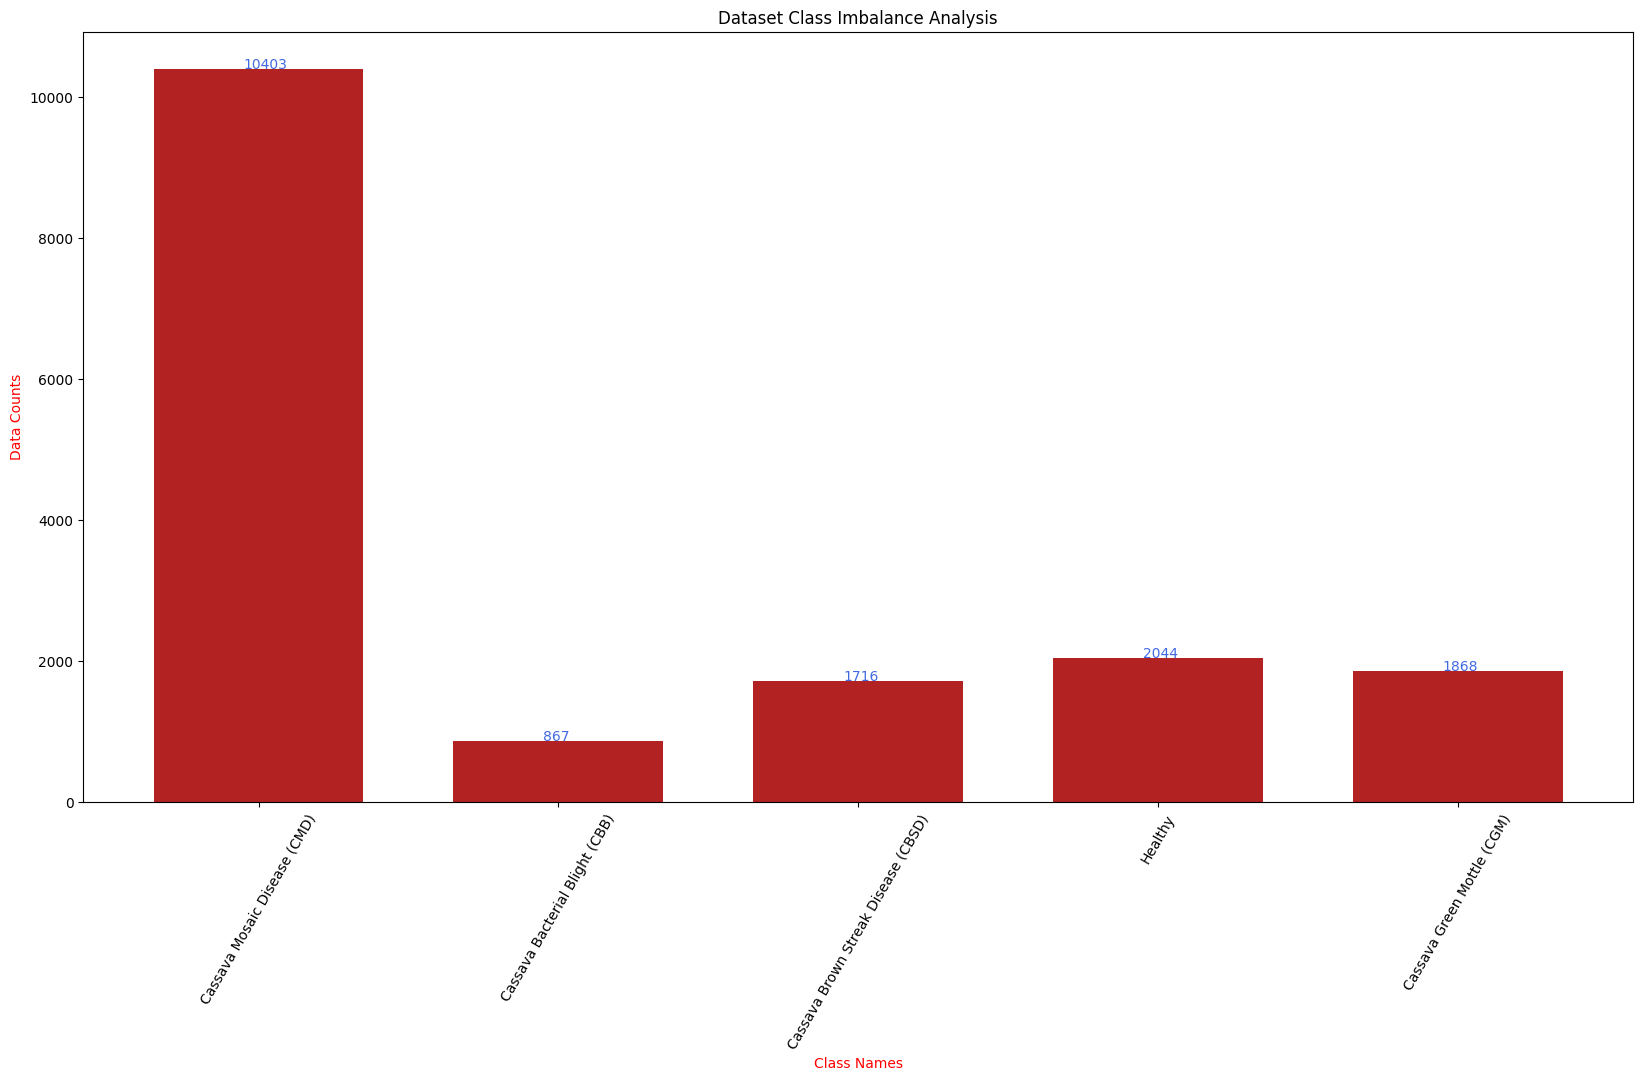

In [ ]:
def data_analysis(root, transformations):
    ds = CustomDataset(root=root, transformations=transformations)
    cls_counts, width, text_width = ds.cls_counts, 0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())
    fig, ax = plt.subplots(figsize=(20, 10))
    indices = np.arange(len(counts))
    ax.bar(indices, counts, width, color="firebrick")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60)
    ax.set(xticks=indices, xticklabels=cls_names)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title(f"Dataset Class Imbalance Analysis")
    for i, v in enumerate(counts):
        ax.text(i - text_width, v + text_height, str(v), color="royalblue")


data_analysis(root=train_images_path, transformations=tfs)

# **Model Training and Validation**

In [ ]:
!pip install torchmetrics
import timm, torchmetrics
from tqdm import tqdm

# Create the model
m = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes))

# Initialize device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
def train_setup(m, device):
    return (
        m.to(device).eval(),  # Move model to the specified device
        10,                   # Number of epochs
        device,               # Device ("cuda" or "cpu")
        torch.nn.CrossEntropyLoss(),
        torch.optim.Adam(params=m.parameters(), lr=3e-4),
    )
def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1, f1_score):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return (
        loss,
        epoch_loss + (loss.item()),
        epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item(),
        epoch_f1 + f1_score(preds, gts),
    )

# Initialize training parameters
m, epochs, device, loss_fn, optimizer = train_setup(m, device)
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)
save_prefix, save_dir = "crop", model_save_path
os.makedirs(save_dir, exist_ok=True)

print("\n" + "=" * 50)
print(f"{'Starting Training':^50}")
print("=" * 50 + "\n")

best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []
best_loss = float("inf")

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0

    # Training loop
    total_images = len(tr_dl.dataset)  # Total number of training images
    processed_images = 0  # Counter for processed images
    with tqdm(enumerate(tr_dl), total=len(tr_dl), desc=f"Epoch {epoch + 1} - Training") as pbar:
        for idx, batch in pbar:
            ims, gts = to_device(batch, device)
            loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(
                m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1, f1_score
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update processed image count
            processed_images += ims.size(0)

            # Update progress bar with total and processed image counts
            pbar.set_postfix({
                "Total Images": total_images,
                "Processed": processed_images,
                "Loss": f"{loss.item():.3f}"
            })

    # Track training metrics
    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_f1_to_track = epoch_f1 / len(tr_dl)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)
    tr_f1s.append(tr_f1_to_track)

    print("\n" + "-" * 50)
    print(f"{'Training Results':^50}")
    print("-" * 50)
    print(f"Epoch {epoch + 1} - Loss: \033[91m{tr_loss_to_track:.3f}\033[0m")
    print(f"Epoch {epoch + 1} - Accuracy: \033[92m{tr_acc_to_track:.3f}\033[0m")
    print(f"Epoch {epoch + 1} - F1 Score: \033[94m{tr_f1_to_track:.3f}\033[0m")
    print("-" * 50 + "\n")

    # Validation loop
    m.eval()
    total_val_images = len(val_dl.dataset)  # Total number of validation images
    processed_val_images = 0  # Counter for processed validation images
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(
                m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1, f1_score
            )

            # Update processed validation image count
            processed_val_images += ims.size(0)

        # Track validation metrics
        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_f1_to_track = val_epoch_f1 / len(val_dl)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)
        val_f1s.append(val_f1_to_track)

        print("\n" + "-" * 50)
        print(f"{'Validation Results':^50}")
        print("-" * 50)
        print(f"Epoch {epoch + 1} - Loss: \033[91m{val_loss_to_track:.3f}\033[0m")
        print(f"Epoch {epoch + 1} - Accuracy: \033[92m{val_acc_to_track:.3f}\033[0m")
        print(f"Epoch {epoch + 1} - F1 Score: \033[94m{val_f1_to_track:.3f}\033[0m")
        print(f"Total Validation Images: {total_val_images}")
        print(f"Processed Validation Images: {processed_val_images}")
        print("-" * 50 + "\n")

        # Save the best model
        if val_loss_to_track < (best_loss + threshold):
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            print(f"\033[92mModel saved at epoch {epoch + 1} with loss {best_loss:.3f}\033[0m\n")
        else:
            not_improved += 1
            print(f"\033[93mLoss did not decrease for {not_improved} epochs\033[0m")
            if not_improved == patience:
                print(f"\033[91mStopping training due to no improvement for {patience} epochs.\033[0m")
                break

print("\n" + "=" * 50)
print(f"{'Training Completed':^50}")
print("=" * 50 + "\n")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Using device: cuda

                Starting Training                 



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 - Training: 100%|██████████| 476/476 [29:43<00:00,  3.75s/it, Total Images=15208, Processed=15208, Loss=0.066]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 1 - Loss: 0.703
Epoch 1 - Accuracy: 0.759
Epoch 1 - F1 Score: 0.760
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 1 - Loss: 0.501
Epoch 1 - Accuracy: 0.831
Epoch 1 - F1 Score: 0.833
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Model saved at epoch 1 with loss 0.501



Epoch 2 - Training: 100%|██████████| 476/476 [03:13<00:00,  2.47it/s, Total Images=15208, Processed=15208, Loss=0.520]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 2 - Loss: 0.458
Epoch 2 - Accuracy: 0.843
Epoch 2 - F1 Score: 0.843
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 2 - Loss: 0.490
Epoch 2 - Accuracy: 0.838
Epoch 2 - F1 Score: 0.838
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Model saved at epoch 2 with loss 0.490



Epoch 3 - Training: 100%|██████████| 476/476 [03:11<00:00,  2.49it/s, Total Images=15208, Processed=15208, Loss=0.293]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 3 - Loss: 0.381
Epoch 3 - Accuracy: 0.868
Epoch 3 - F1 Score: 0.869
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 3 - Loss: 0.438
Epoch 3 - Accuracy: 0.846
Epoch 3 - F1 Score: 0.848
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Model saved at epoch 3 with loss 0.438



Epoch 4 - Training: 100%|██████████| 476/476 [03:12<00:00,  2.47it/s, Total Images=15208, Processed=15208, Loss=0.287]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 4 - Loss: 0.320
Epoch 4 - Accuracy: 0.888
Epoch 4 - F1 Score: 0.888
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 4 - Loss: 0.476
Epoch 4 - Accuracy: 0.841
Epoch 4 - F1 Score: 0.843
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Loss did not decrease for 1 epochs


Epoch 5 - Training: 100%|██████████| 476/476 [03:13<00:00,  2.46it/s, Total Images=15208, Processed=15208, Loss=0.214]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 5 - Loss: 0.258
Epoch 5 - Accuracy: 0.912
Epoch 5 - F1 Score: 0.912
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 5 - Loss: 0.495
Epoch 5 - Accuracy: 0.841
Epoch 5 - F1 Score: 0.841
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Loss did not decrease for 2 epochs


Epoch 6 - Training: 100%|██████████| 476/476 [03:16<00:00,  2.43it/s, Total Images=15208, Processed=15208, Loss=0.010]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 6 - Loss: 0.197
Epoch 6 - Accuracy: 0.929
Epoch 6 - F1 Score: 0.929
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 6 - Loss: 0.565
Epoch 6 - Accuracy: 0.839
Epoch 6 - F1 Score: 0.841
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Loss did not decrease for 3 epochs


Epoch 7 - Training: 100%|██████████| 476/476 [03:15<00:00,  2.43it/s, Total Images=15208, Processed=15208, Loss=0.346]



--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 7 - Loss: 0.158
Epoch 7 - Accuracy: 0.947
Epoch 7 - F1 Score: 0.947
--------------------------------------------------


--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 7 - Loss: 0.560
Epoch 7 - Accuracy: 0.847
Epoch 7 - F1 Score: 0.849
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Loss did not decrease for 4 epochs


Epoch 8 - Training: 100%|██████████| 476/476 [03:15<00:00,  2.43it/s, Total Images=15208, Processed=15208, Loss=0.009]


--------------------------------------------------
                 Training Results                 
--------------------------------------------------
Epoch 8 - Loss: 0.121
Epoch 8 - Accuracy: 0.959
Epoch 8 - F1 Score: 0.959
--------------------------------------------------




--------------------------------------------------
                Validation Results                
--------------------------------------------------
Epoch 8 - Loss: 0.691
Epoch 8 - Accuracy: 0.838
Epoch 8 - F1 Score: 0.840
Total Validation Images: 844
Processed Validation Images: 844
--------------------------------------------------

Loss did not decrease for 5 epochs
Stopping training due to no improvement for 5 epochs.

                Training Completed                



# **Learning Curves Visualization**

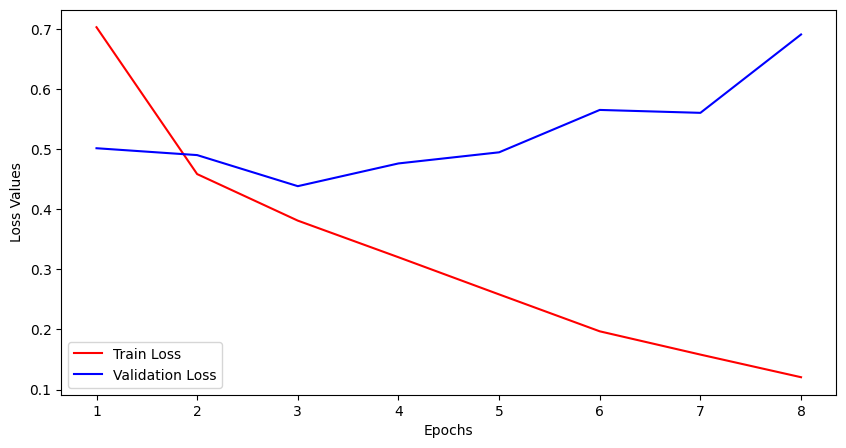

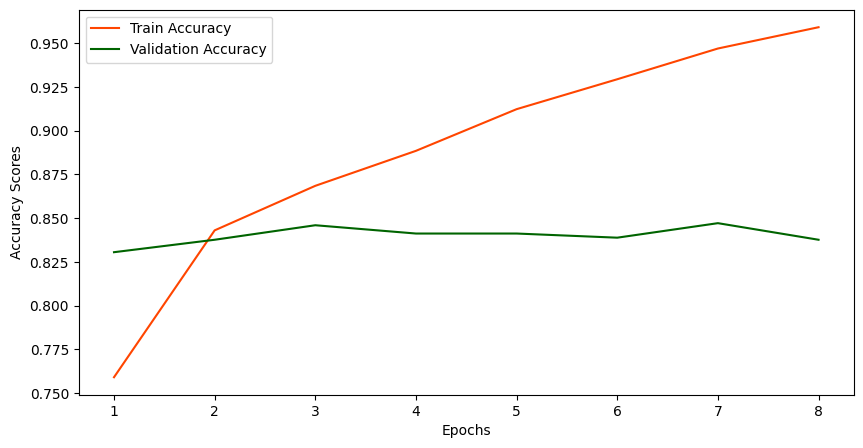

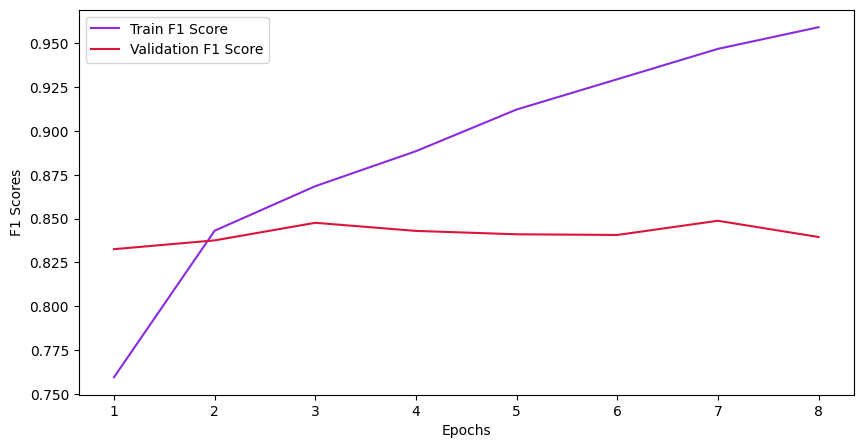

In [ ]:
class PlotLearningCurves:
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = (
            tr_losses,
            val_losses,
            tr_accs,
            val_accs,
            tr_f1s,
            val_f1s,
        )

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        plt.plot(array_1, label=label_1, c=color_1)
        plt.plot(array_2, label=label_2, c=color_2)

    def create_figure(self):
        plt.figure(figsize=(10, 5))

    def decorate(self, ylabel, xlabel="Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(
            ticks=np.arange(len(self.tr_accs)),
            labels=[i for i in range(1, len(self.tr_accs) + 1)],
        )
        plt.legend()
        plt.show()

    def visualize(self):
        # Figure 1
        self.create_figure()
        self.plot(
            array_1=self.tr_losses,
            array_2=self.val_losses,
            label_1="Train Loss",
            label_2="Validation Loss",
            color_1="red",
            color_2="blue",
        )
        self.decorate(ylabel="Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(
            array_1=self.tr_accs,
            array_2=self.val_accs,
            label_1="Train Accuracy",
            label_2="Validation Accuracy",
            color_1="orangered",
            color_2="darkgreen",
        )
        self.decorate(ylabel="Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(
            array_1=[tr_f1.cpu() for tr_f1 in self.tr_f1s],
            array_2=[vl_f1.cpu() for vl_f1 in self.val_f1s],
            label_1="Train F1 Score",
            label_2="Validation F1 Score",
            color_1="blueviolet",
            color_2="crimson",
        )
        self.decorate(ylabel="F1 Scores")


PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

# **Inference and GradCAM Visualization**

<ipython-input-9-a41099da58c9>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
/usr/local/lib/pyt

Accuracy of the model on the test data -> 0.865


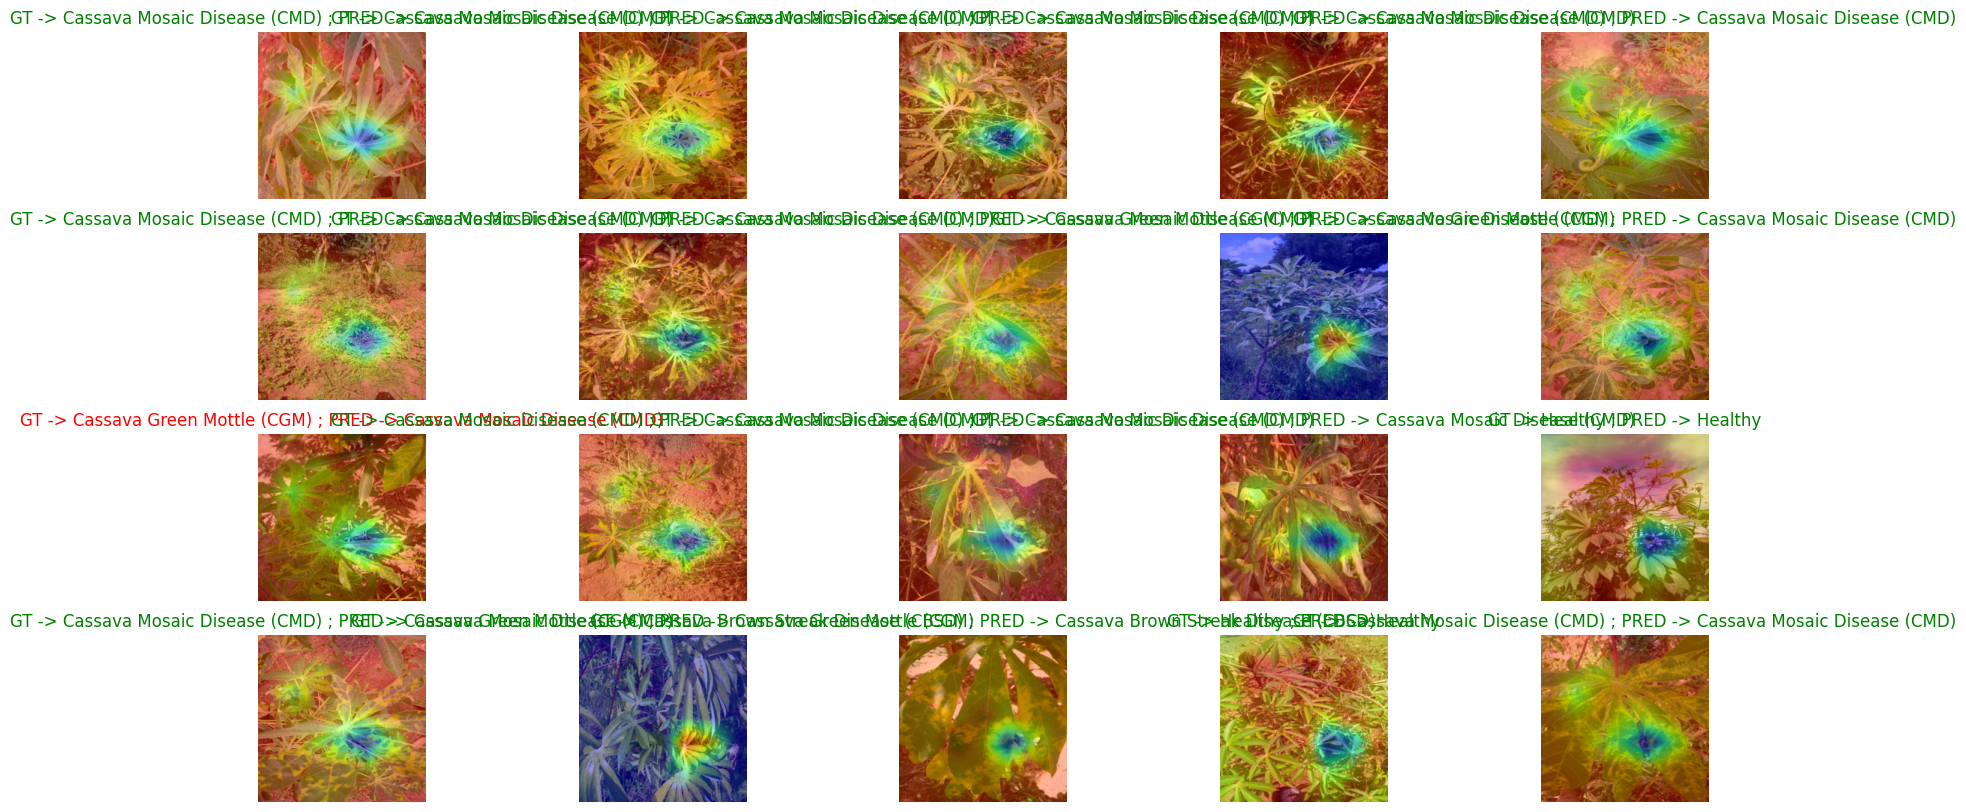

In [ ]:
import cv2


class SaveFeatures:
    """Extract pretrained activations"""

    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()


def getCAM(conv_fs, linear_weights, class_idx):
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0, :, :,].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    return (cam - np.min(cam)) / np.max(cam)


def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names=None):
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim=1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())
    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indekslar):
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap="gray")
        plt.axis("off")
        plt.imshow(
            cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR),
            alpha=0.4,
            cmap="jet",
        )
        plt.axis("off")
        if cls_names is not None:
            plt.title(
                f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}",
                color=("green" if cls_names[int(lbls[indeks])] == cls_names[int(preds[indeks])] else "red"),
            )
        else:
            plt.title(f"GT -> {gt} ; PRED -> {pred}")


m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(
    model=m.to(device),
    device=device,
    test_dl=ts_dl,
    num_ims=20,
    row=4,
    cls_names=list(classes.values()),
    final_conv=final_conv,
    fc_params=fc_params,
)